<a href="https://colab.research.google.com/github/FranciscaHerr/AA-II-Herrera-RodriguezyBarros-Zahradnicek/blob/main/TP2_AAII_EJ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aprendizaje Automático 2
### TP 2 - Redes Recurrentes
#### Problema 1 - Audio MNIST

## Enunciado

En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos hablados del 0 al 9.

**Dataset:**
https://www.tensorflow.org/datasets/catalog/spoken_digit

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor.

**Objetivo:**

Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:
* Modelo convolucional sobre los espectrogramas de los clips.
* Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.

**Entrega:**

Código fuente de la solución implementada en Google Colab, que incluya:
* Análisis previo y preprocesamiento del set de datos.
* Definición y entrenamiento del modelo.
* Resultados de la evaluación de los modelos, incluyendo métricas de desempeño y visualizaciones relevantes.


##Setup

Se importan las librerías y dependencias necesarias, y se fija el valor de la semilla para lograr reproducibilidad.

In [1]:
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import shutil
import collections
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from IPython import display
from sklearn.model_selection import train_test_split

# Configuración inicial
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Establecer GPU por defecto en caso de estar disponible

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Carga de Datos

In [3]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 30.32 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [4]:
# Ruta donde están los audios
audio_path = '/content/free-spoken-digit-dataset/recordings'

# Verificación de archivos
audio_files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]
print("Total de audios:", len(audio_files))
print("Ejemplo de archivos:", audio_files[:5])  # {digitLabel}_{speakerName}_{index}.wav

# Verificación de balance
labels = [fname.split('_')[0] for fname in audio_files]
counts = Counter(labels)
print("Distribución de clases:", counts.most_common())  # Ordenado por frecuencia

Total de audios: 3000
Ejemplo de archivos: ['5_jackson_11.wav', '4_yweweler_40.wav', '6_lucas_41.wav', '3_yweweler_8.wav', '6_nicolas_20.wav']
Distribución de clases: [('5', 300), ('4', 300), ('6', 300), ('3', 300), ('8', 300), ('1', 300), ('7', 300), ('0', 300), ('2', 300), ('9', 300)]


Se cuentan los archivos de audio por dígito, observándose que el dataset está balanceado.

#### Creación del dataframe

In [5]:
data = []
for file in audio_files:
    try:
        data.append({
            'file': os.path.join(audio_path, file),
            'label': int(file.split('_')[0]),  # Convertir la etiqueta a int
            'speaker': file.split('_')[1],  # Extraemos el speaker
            'index': int(file.split('_')[2].split('.')[0])  # Extraemos el índice
        })
    except Exception as e:
        print(f"Error procesando archivo {file}: {str(e)}")

df = pd.DataFrame(data)

# Verificación adicional
print("\nMuestra del dataframe:")
print(df.head())
print("\nTipos de datos:")
print(df.dtypes)


Muestra del dataframe:
                                                file  label   speaker  index
0  /content/free-spoken-digit-dataset/recordings/...      5   jackson     11
1  /content/free-spoken-digit-dataset/recordings/...      4  yweweler     40
2  /content/free-spoken-digit-dataset/recordings/...      6     lucas     41
3  /content/free-spoken-digit-dataset/recordings/...      3  yweweler      8
4  /content/free-spoken-digit-dataset/recordings/...      6   nicolas     20

Tipos de datos:
file       object
label       int64
speaker    object
index       int64
dtype: object


Organización del dataset por etiquetas

In [6]:
# Se organizan los audios en carpetas según su etiqueta
data_dir = 'organized_audio'
os.makedirs(data_dir, exist_ok=True)

for _, row in df.iterrows():
    label_dir = os.path.join(data_dir, str(row['label']))
    os.makedirs(label_dir, exist_ok=True)
    shutil.copy2(row['file'], label_dir) # copiamos el audio a su carpeta correspondiente

####Separación de datos en train y validation

In [7]:
# Separación train test
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=seed,
    output_sequence_length=8000, # audios de 8000 muestras por segundo
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Using 600 files for validation.

label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


##Análisis exploratorio

In [8]:
# Shape train_ds
train_ds.element_spec

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [9]:
# Shape val_ds
val_ds.element_spec

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
#64 ejemplos en el batch #8000 muestras por audio #1 canal (mono)
for audio, label in train_ds.take(1):
    print(audio.shape)

(64, 8000, 1)


In [11]:
# Función para la eliminación del eje extra
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# Se aplica la función squeeze a cada elemento de train y val
# tf.data.AUTOTUNE permite la optimización del paralelismo en el procesamiento
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# Validación
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 8000)
(64,)


Ploteamos tres formas de onda por clase para poder compararlas entre sí

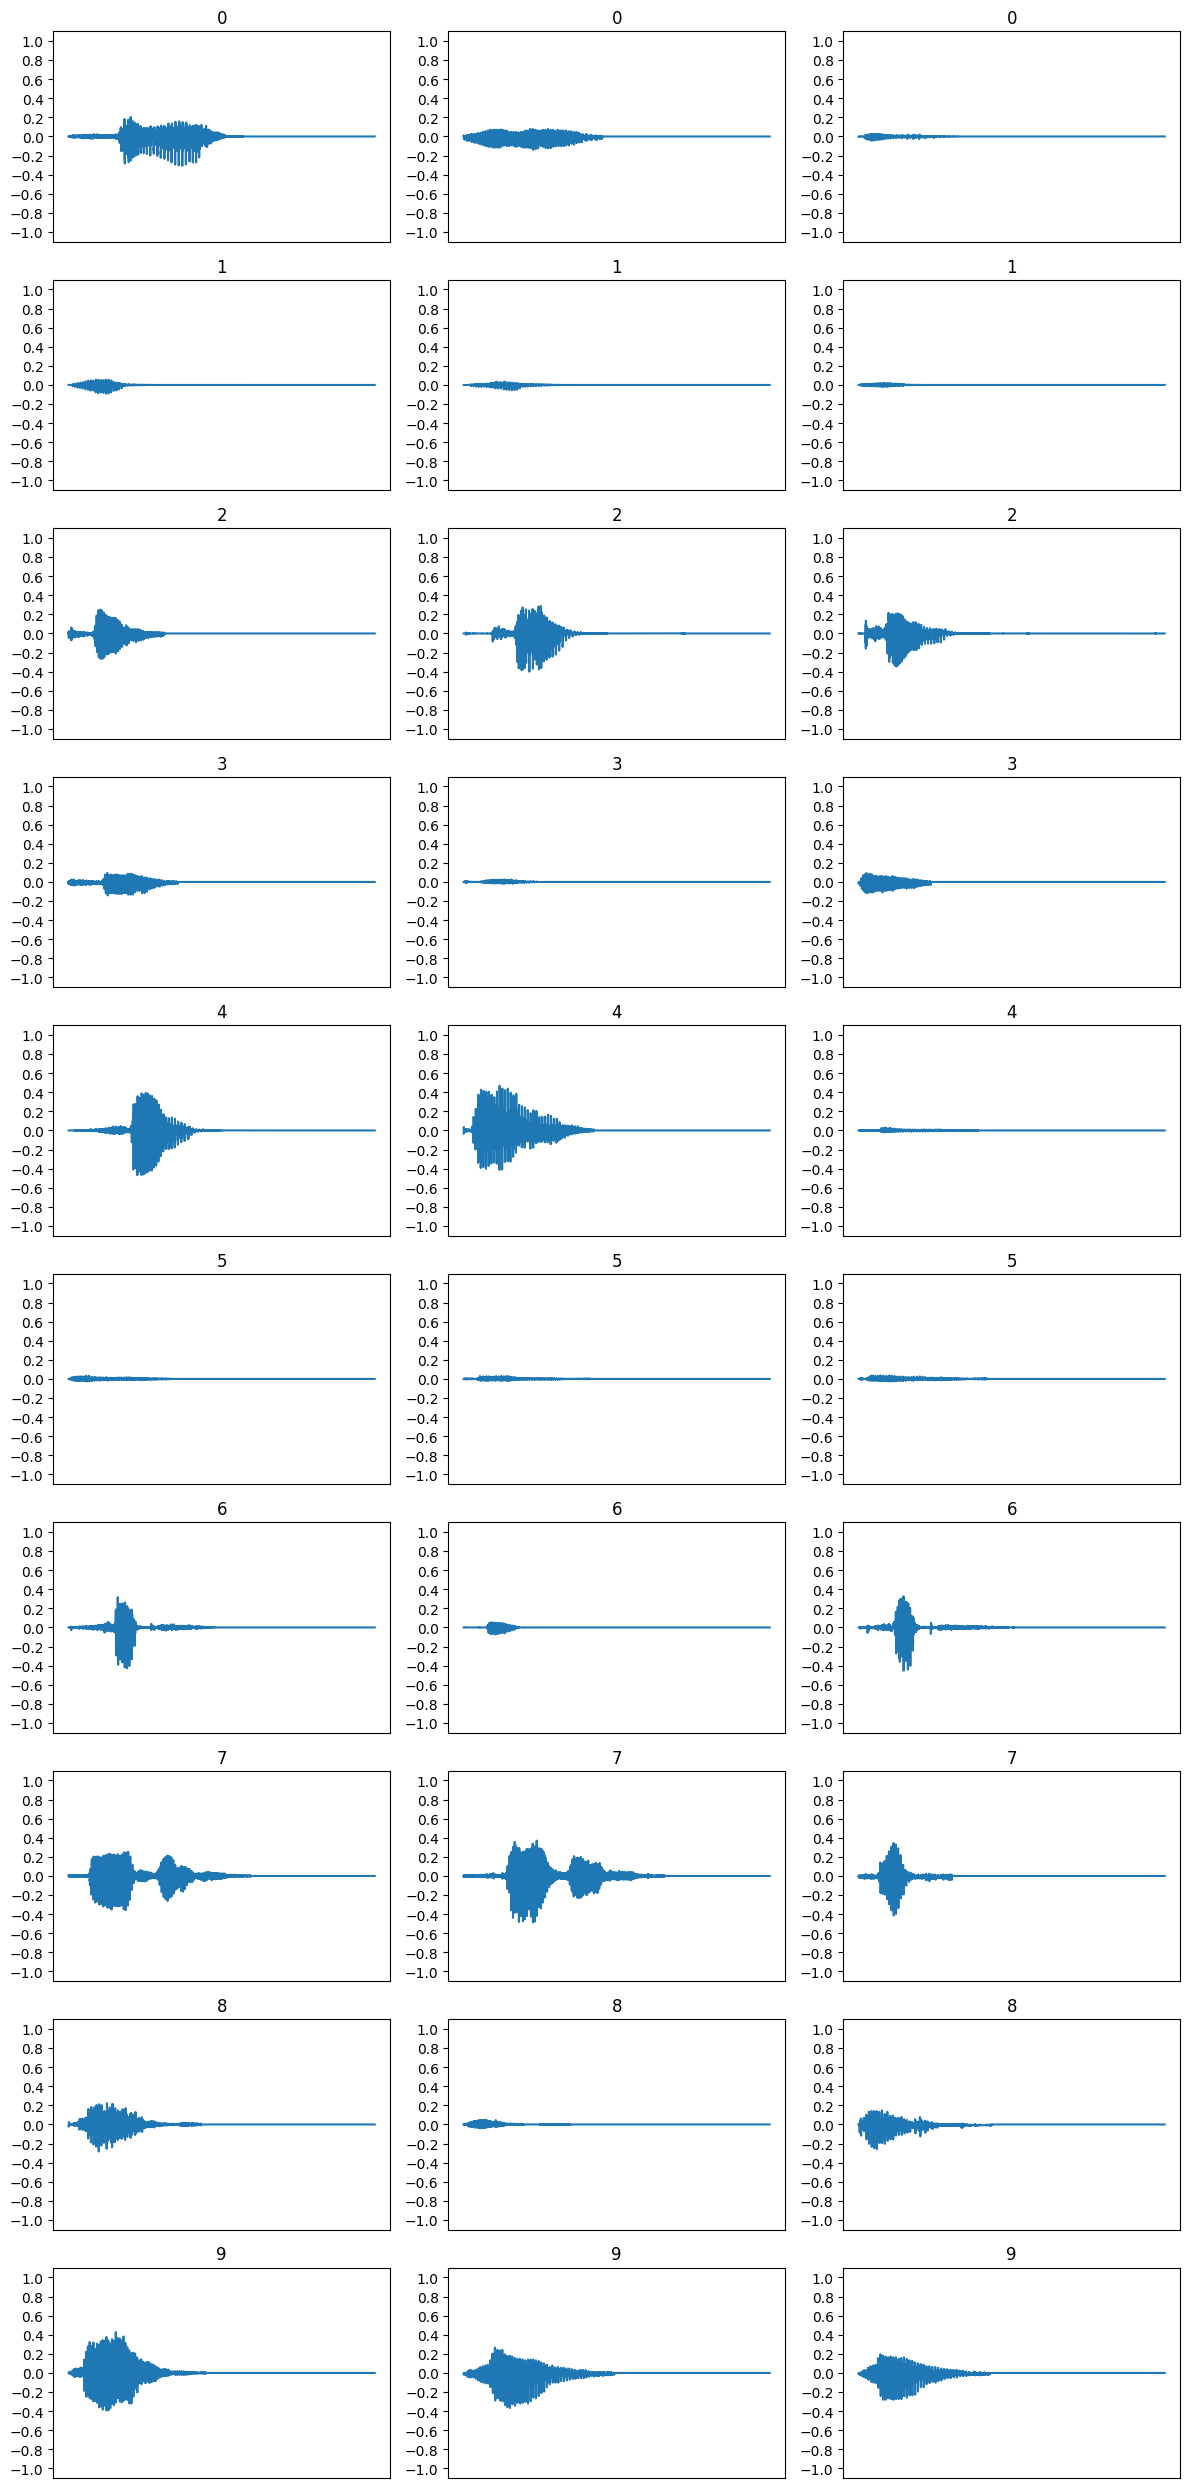

In [12]:
# Creamos un diccionario para guardar 3 audios por clase
samples_per_label = {}
num_examples_per_class = 3

# Recorremos el dataset y juntamos ejemplos por etiqueta
for audios, labels in train_ds.unbatch(): # unbatch devuelve ejemplos individuales
    label = labels.numpy()
    if label not in samples_per_label:
        samples_per_label[label] = []
    if len(samples_per_label[label]) < num_examples_per_class:
        samples_per_label[label].append(audios.numpy())
    if all(len(v) == num_examples_per_class for v in samples_per_label.values()) and \
       len(samples_per_label) == len(label_names):
        break  # Cortamos cuando ya tenemos 3 ejemplos por cada clase

# Ordenamos por etiqueta
sorted_labels = sorted(samples_per_label.keys())

# Parámetros del gráfico
rows = len(sorted_labels)
cols = num_examples_per_class
plt.figure(figsize=(cols * 4, rows * 2.5))

# Ploteamos
for row, label in enumerate(sorted_labels):
    for col in range(num_examples_per_class):
        index = row * cols + col + 1
        plt.subplot(rows, cols, index)
        plt.plot(samples_per_label[label][col])
        plt.title(f"{label_names[label]}")
        plt.yticks(np.arange(-1.2, 1.2, 0.2))
        plt.ylim([-1.1, 1.1])
        plt.xticks([])

plt.tight_layout()
plt.show()

##Conversión de formas de onda a espectrogramas

El frame_length es la cantidad de muestras que abarca cada ventana de análisis en la Transformada de Fourier, afectando la resolución en frecuencia: ventanas más largas mejoran la precisión para distinguir frecuencias, pero reducen la resolución temporal. El frame_step es el salto entre ventanas consecutivas, determinando la superposición; un valor menor genera más superposición y mejor continuidad temporal. Los valores 255 para frame_length y 128 para frame_step son típicos para audios con frecuencia de muestreo baja/moderada (como 8kHz).  

In [13]:
def get_spectrogram(waveform):
  # Convierte la onda en un espectrograma mediante una Transformada Rápida de Fourier (STFT)
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  # Obtiene el valor absoluto del STFT
  spectrogram = tf.abs(spectrogram)
  # Agrega una dimensión de 'canal', para que el espectrograma pueda usarse
  # como entrada tipo imagen en capas convolucionales (que esperan forma
  # ('batch_size', 'alto', 'ancho', 'canales'))
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
# Reproducción de ejemplos de audio
for i in range(10):
  label = label_names[example_labels[i]]   # Obtener la etiqueta del ejemplo i-ésimo
  waveform = example_audio[i]   # Obtener la forma de onda del ejemplo i-ésimo
  spectrogram = get_spectrogram(waveform)  # Calcular el espectrograma a partir de la forma de onda

  # Imprimir características del audio
  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=8000))

Label: 3
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 6
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 8
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 6
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 6
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 0
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 4
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 7
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 0
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 1
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


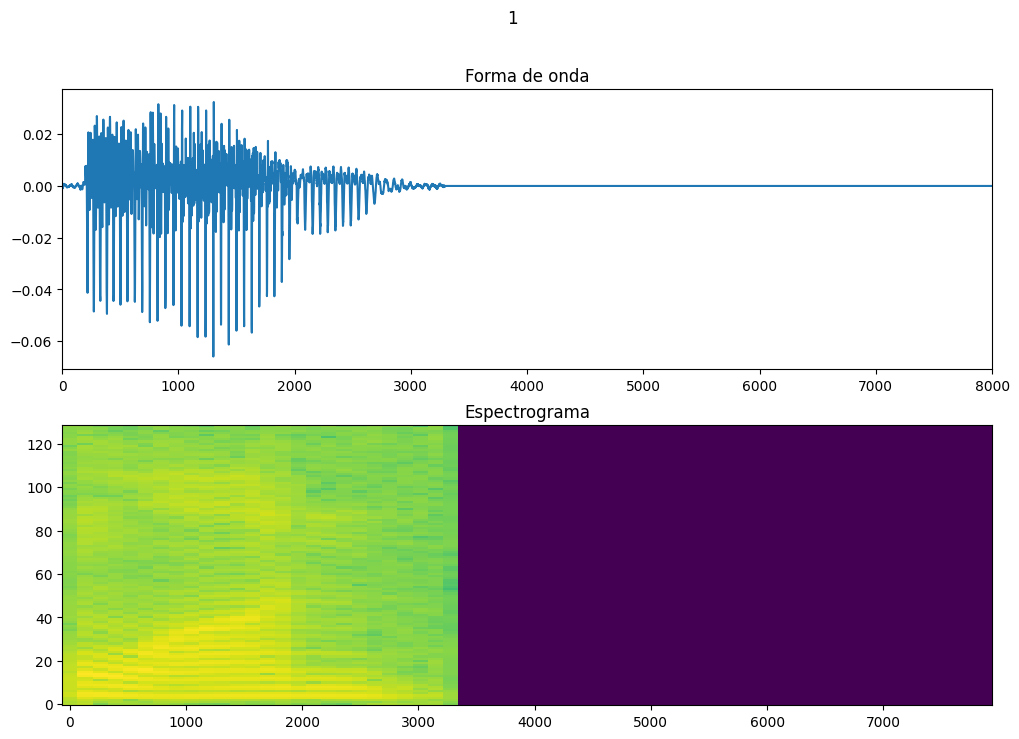

In [15]:
# Función para graficar un espectrograma
def plot_spectrogram(spectrogram, ax):
  # Si el espectrograma tiene más de 2 dimensiones, eliminamos la dimensión extra
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  # Convertimos las frecuencias a escala logarítmica y transponemos,
  # para que el tiempo se represente en el eje x.
  # Se suma un valor muy pequeño (epsilon) para evitar el logaritmo de cero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)

  # Generamos los valores para los ejes X (tiempo) y Y (frecuencia)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)

  # Graficamos el espectrograma como un mapa de colores
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
# Creamos un vector de tiempo para la forma de onda
timescale = np.arange(waveform.shape[0])
# Graficamos la forma de onda en el primer subplot
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Forma de onda')
axes[0].set_xlim([0, 8000])
# Graficamos el espectrograma en el segundo subplot
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Espectrograma')
# Título general con la etiqueta del audio
plt.suptitle(label.title())
plt.show()

Conversión de datasets de entrenamiento y validación a espectrogramas

In [16]:
# Función que devuelve un nuevo dataset donde cada forma de onda es convertida en espectrograma
def make_spec_ds(ds):
  # Aplica la función get_spectrogram a cada ejemplo del dataset
  # Mantiene las etiquetas sin cambios
  # Ejecuta las llamadas en paralelo para optimizar el rendimiento
  return ds.map(
      map_func=lambda audio, label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

# Dataset de espectrogramas para entrenamiento
train_spectrogram_ds = make_spec_ds(train_ds)

# Dataset de espectrogramas para validación
val_spectrogram_ds = make_spec_ds(val_ds)

Visualización de tres espectrogramas por clase

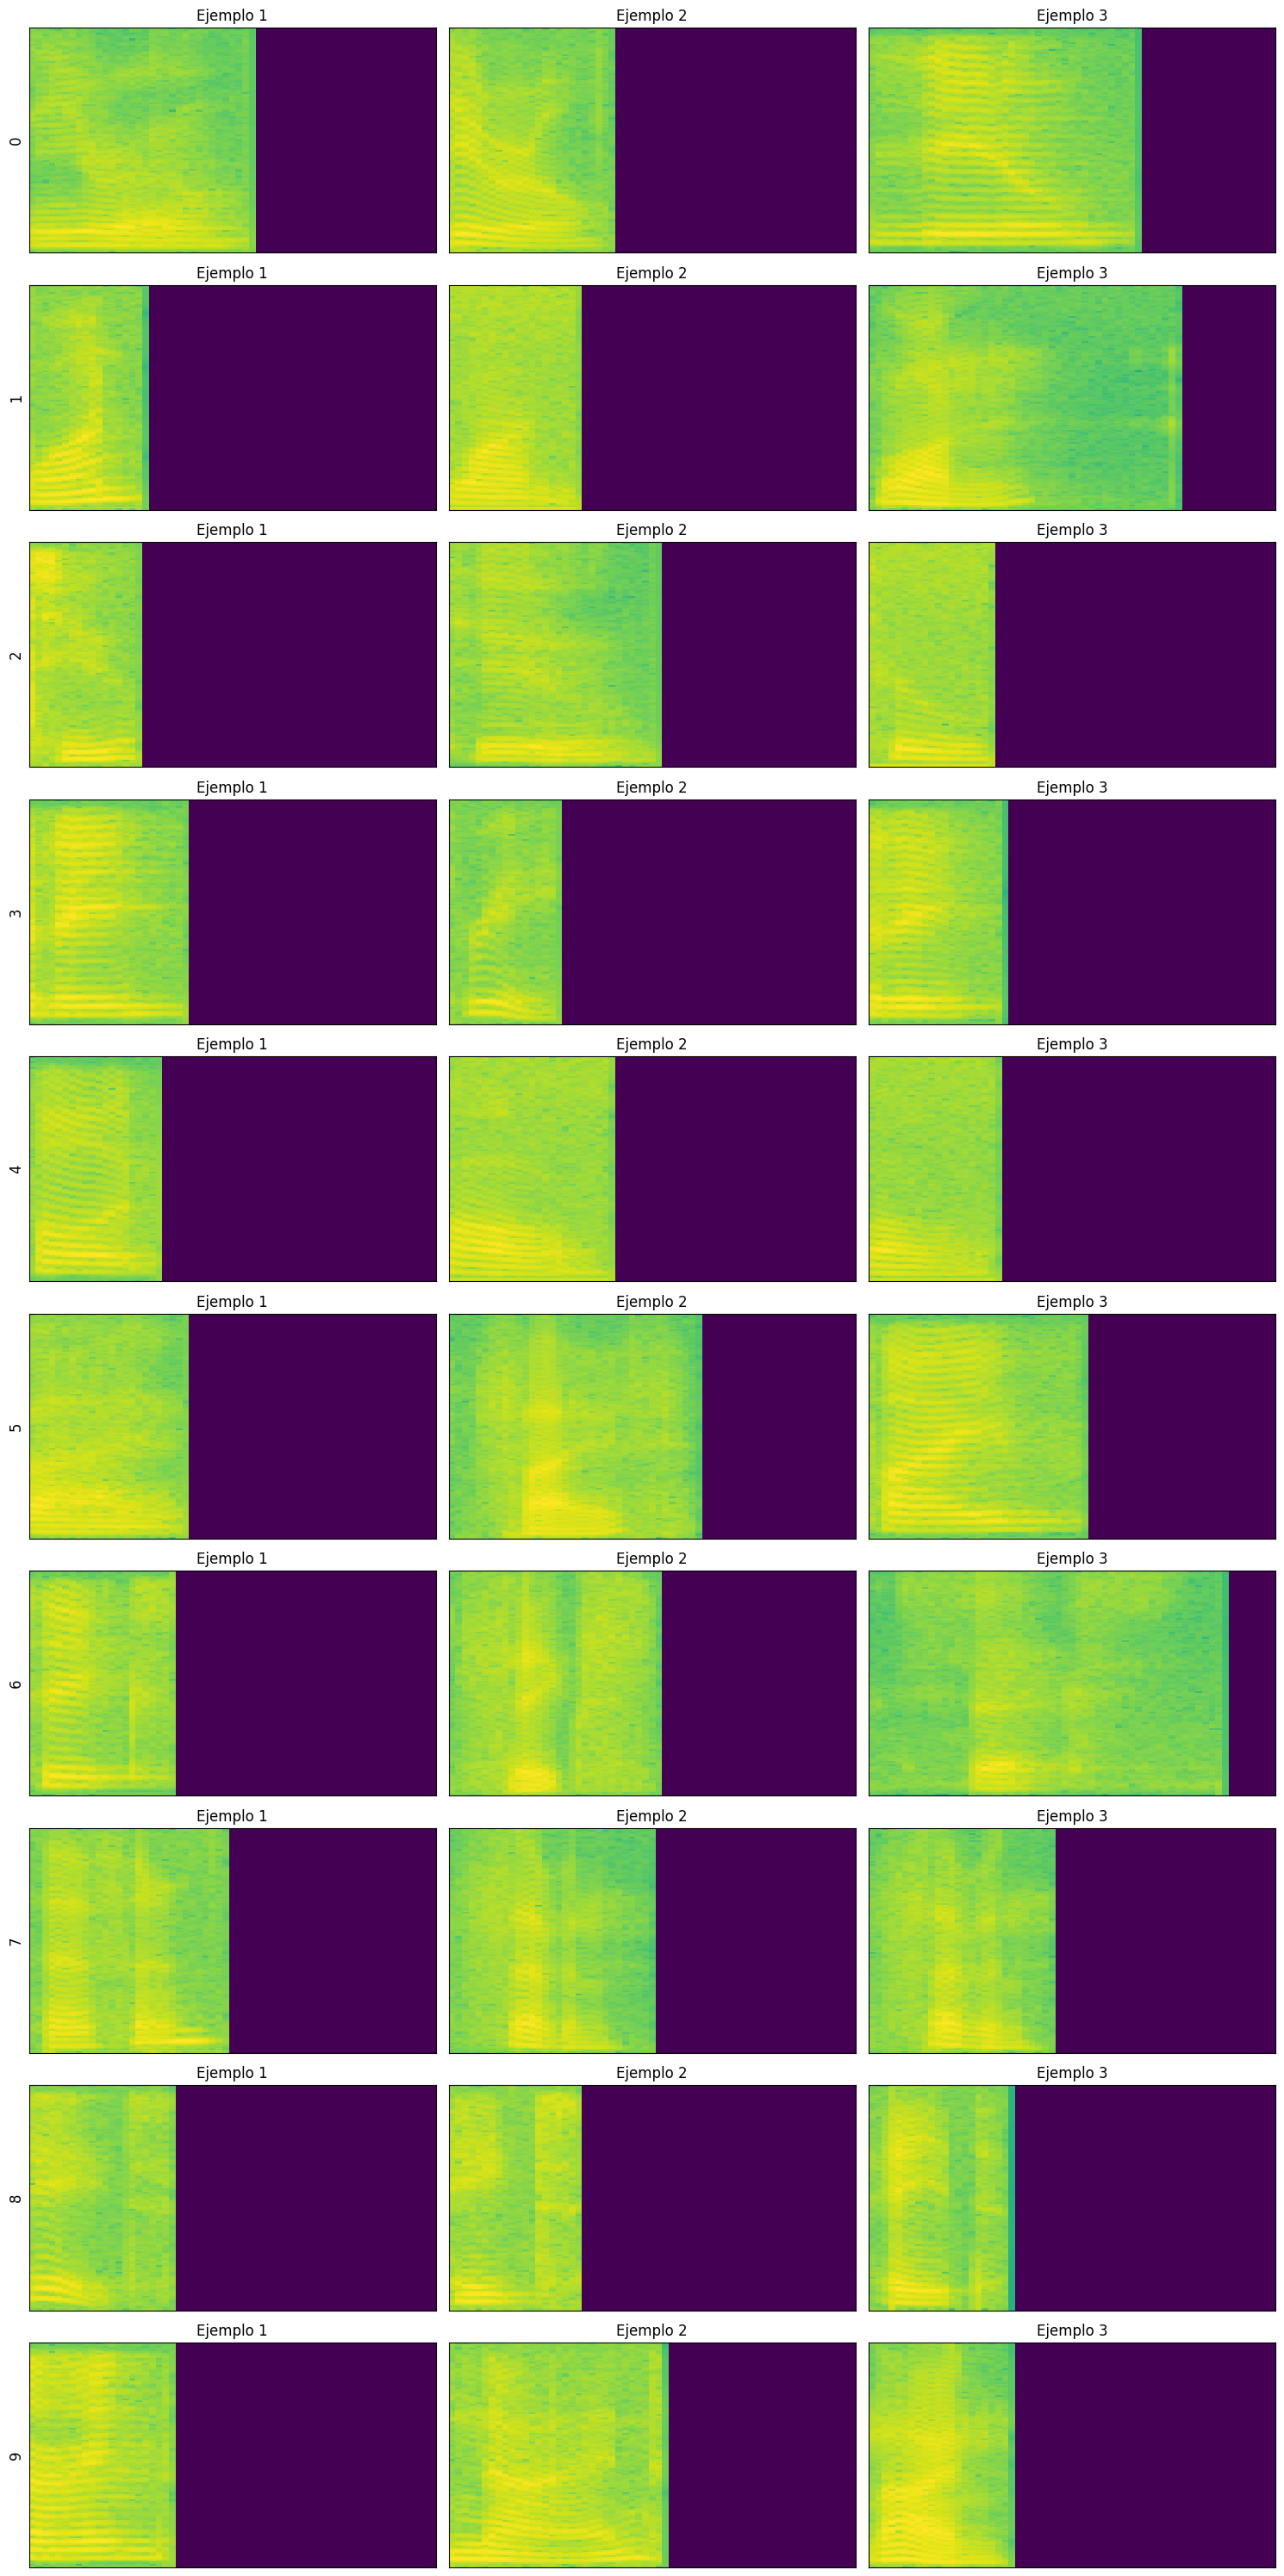

In [17]:
# Extraemos ejemplos individuales del dataset (sin batching)
unbatched_ds = train_spectrogram_ds.unbatch()

# Crear un diccionario donde la clave es la clase
# y el valor es una lista de espectrogramas que pertenecen a esa clase
ejemplos_por_clase = collections.defaultdict(list)

# Iteramos por cada par (espectrograma, etiqueta) individual del dataset
for spec, label in unbatched_ds:
    label_idx = label.numpy() # Convertimos el label de tensor a entero
    if len(ejemplos_por_clase[label_idx]) < 3:
        ejemplos_por_clase[label_idx].append(spec.numpy())

    # Cortamos si ya tenemos 3 de cada clase
    if all(len(ejemplos) == 3 for ejemplos in ejemplos_por_clase.values()) and len(ejemplos_por_clase) == len(label_names):
      break

# Configuramos la figura
rows = len(label_names)
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Graficamos los espectrogramas
for label_idx, espectros in ejemplos_por_clase.items():
    for i in range(3):
        ax = axes[label_idx][i] if rows > 1 else axes[i]
        plot_spectrogram(espectros[i], ax)
        if i == 0:
            ax.set_ylabel(label_names[label_idx], fontsize=12)
        ax.set_title(f"Ejemplo {i+1}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

##CNN

###Arquitectura

Para el modelado se utilizará una red neuronal convolucional simple (CNN), a partir de las imágenes de espectrogramas generadas de los archivos de audio.

In [ ]:
# NOTA: Celdas de entrenamiento comentadas para usar modelo pre-entrenado
# Descomentar solo si se necesita reentrenamiento desde cero [!]

In [ ]:
'''
# Obtención del tamaño del buffer para mezclar datos, equilibrando rendimiento y uso de memoria
train_size = 2400
val_size = 600
shuffle_buffer = min(1000, train_size // 2)

# Optimización de la carga y procesamiento de los datasets

train_spectrogram_ds = (train_spectrogram_ds
                       .cache()  # Guarda el dataset en memoria para acelerar accesos posteriores
                       .shuffle(shuffle_buffer)  # Mezcla aleatoriamente los ejemplos para mejorar el entrenamiento
                       .prefetch(tf.data.AUTOTUNE))  # Pre-carga datos mientras la GPU está ocupada

val_spectrogram_ds = (val_spectrogram_ds
                     .cache()  # Guarda el dataset en memoria para acelerar accesos posteriores
                     .prefetch(tf.data.AUTOTUNE))  # Pre-carga datos para mejorar eficiencia durante la validación
'''

In [ ]:
'''
# Extraemos un batch para obtener el shape
for example_spectrograms, _ in train_spectrogram_ds.take(1):
    input_shape = example_spectrograms.shape[1:]
    break

print('Input shape:', input_shape)
num_labels = len(label_names)

# Para normalizar los datos de entrada, instanciamos la capa norm
norm_layer = layers.Normalization()
# Calculamos la media y desviación estándar de los espectrogramas de entrenamiento
norm_layer.adapt(train_spectrogram_ds.map(lambda spec, label: spec))

# Definición de la arquitectura del modelo CNN
# para clasificación de espectrogramas
model = models.Sequential([
    layers.Input(shape=input_shape),                # Capa de entrada
    layers.Resizing(32, 32),                        # Redimensiona a 32x32
    norm_layer,                                     # Normaliza datos
    layers.Conv2D(32, 3, activation='relu'),        # Conv. 32 filtros
    layers.Conv2D(64, 3, activation='relu'),        # Conv. 64 filtros
    layers.MaxPooling2D(),                          # Pooling para reducir tamaño
    layers.Dropout(0.25),                           # Dropout 25%
    layers.Flatten(),                               # Aplana a vector 1D
    layers.Dense(128, activation='relu'),           # Capa densa 128 neuronas
    layers.Dropout(0.5),                            # Dropout 50%
    layers.Dense(num_labels, activation='softmax')  # Capa de salida con act. softmax (c. multi-clase)
])

model.summary()
'''

Input shape: (61, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
'''
# Compilación del modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # esperando logits con softmax
    metrics=['accuracy'],
)
'''

###Entrenamiento

In [ ]:
'''
# Entrenamiento con early stopping
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)
'''

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.2934 - loss: 2.0123 - val_accuracy: 0.6483 - val_loss: 1.2432
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.5992 - loss: 1.2390 - val_accuracy: 0.7983 - val_loss: 0.8060
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.7213 - loss: 0.8649 - val_accuracy: 0.8517 - val_loss: 0.6040
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.8038 - loss: 0.6458 - val_accuracy: 0.8733 - val_loss: 0.4711
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.8451 - loss: 0.5252 - val_accuracy: 0.9000 - val_loss: 0.3628
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.8640 - loss: 0.4258 - val_accuracy: 0.9183 - val_loss: 0.3055
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.8846 - loss: 0.3600 - val_accuracy: 0.9250 - val_loss: 0.2929
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.9061 - loss: 0.3073 - val_accuracy: 

###Resultados

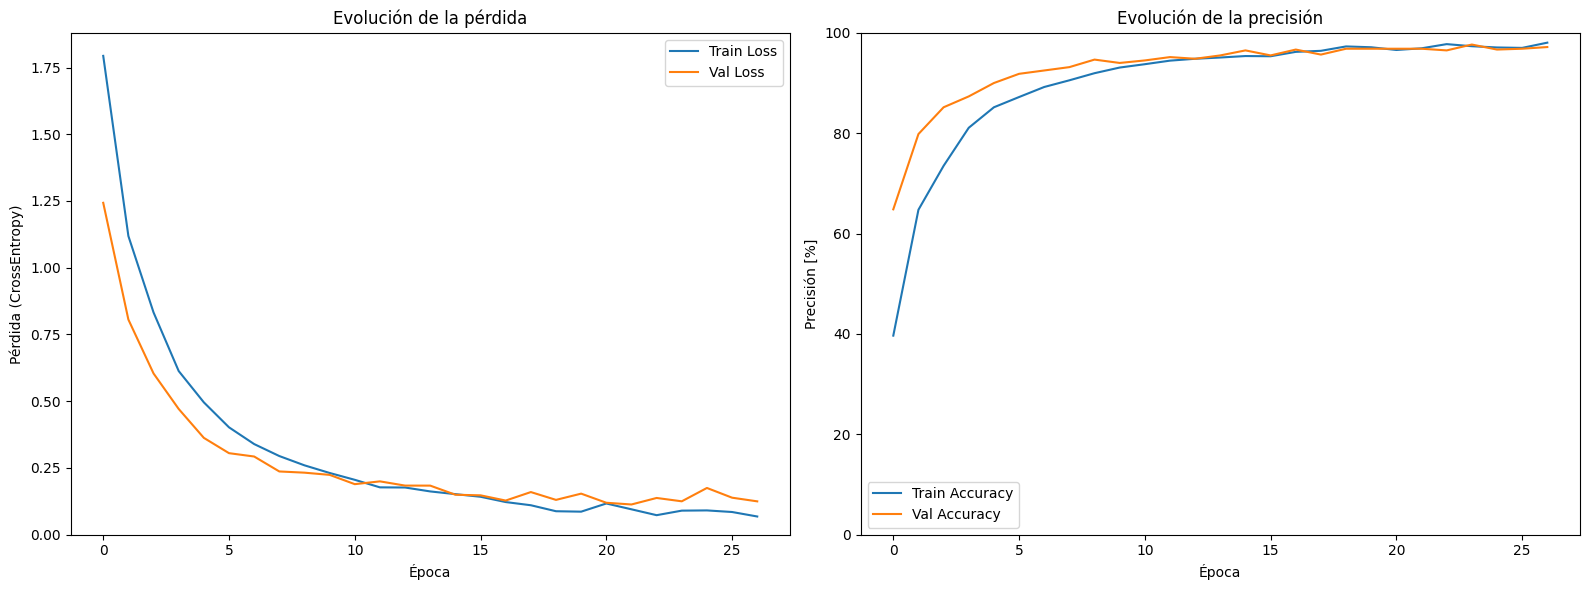

In [ ]:
'''
# Visualización de métricas de entrenamiento y validación
metrics = history.history
plt.figure(figsize=(16, 6))

# Gráfico de la función de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], label='Train Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Val Loss')
plt.legend()
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Época')
plt.ylabel('Pérdida (CrossEntropy)')
plt.title('Evolución de la pérdida')

# Gráfico de la precisión
plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), label='Train Accuracy')
plt.plot(history.epoch, 100 * np.array(metrics['val_accuracy']), label='Val Accuracy')
plt.legend()
plt.ylim([0, 100])
plt.xlabel('Época')
plt.ylabel('Precisión [%]')
plt.title('Evolución de la precisión')

plt.tight_layout()
plt.show()
'''

📌 **Análisis del entrenamiento:**

* Aprendizaje efectivo en las primeras épocas (2–9), con mejoras constantes tanto en el set de entrenamiento como en el de validación.

* Hasta la época 10, la accuracy en validación es superior a la de entrenamiento, lo que puede indicar buena generalización en las primeras etapas. Luego, ambas métricas evolucionan de forma pareja.

* Las curvas de pérdida y precisión muestran una convergencia armónica, aunque a partir de la época 16 se observa una ligera separación en la pérdida, lo que podría sugerir un inicio de sobreajuste.

* En general, el entrenamiento fue exitoso: la red aprendió rápido y alcanzó alta precisión en ambos conjuntos.

* El uso de early stopping fue acertado, previniendo un sobreentrenamiento innecesario y deteniendo el proceso oportunamente.

In [ ]:
'''
# Guardar el modelo como un archivo HDF5
model.save("model_cnn.h5")
'''

Corremos la celda a continuación para validar el rendimiento del modelo cargado, previamente entrenado y descargado.

In [18]:
# 1. Cargar el modelo más tarde, asegurando reproducibilidad
tf.keras.utils.set_random_seed(42)  # Fijar todas las semillas

model = tf.keras.models.load_model('/content/model_cnn.h5')

# 2. Recompilar idéntico al entrenamiento original
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# 3. Evaluación determinista
# Desactivar operaciones no deterministas frente al uso de GPU
tf.config.experimental.enable_op_determinism()

# 4. Reevaluar
results = model.evaluate(val_spectrogram_ds, verbose=0)
print(f"\nResultados finales - Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}")

# 5. Verificación adicional
print("\nComparación con entrenamiento original:")
print(f"Val Accuracy esperado: 0.9717 | Obtenido: {results[1]:.4f}")
print(f"Val Loss esperado: 0.1250 | Obtenido: {results[0]:.4f}")


Resultados finales - Loss: 0.1250, Accuracy: 0.9717

Comparación con entrenamiento original:
Val Accuracy esperado: 0.9717 | Obtenido: 0.9717
Val Loss esperado: 0.1250 | Obtenido: 0.1250


####Matriz de confusión

Se utiliza una matriz de confusión para verificar qué tan bien clasificó el modelo cada uno de los dígitos en el conjunto de validación:

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


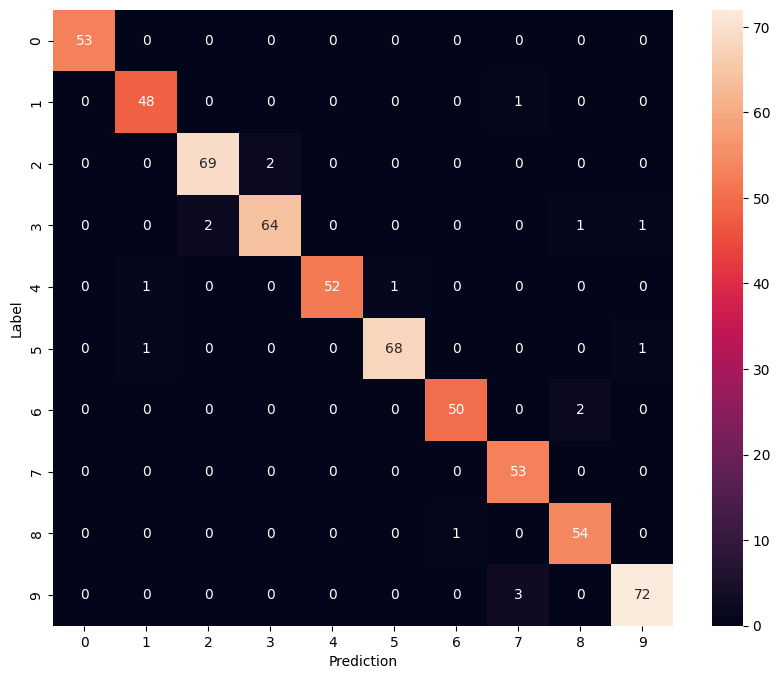

In [19]:
y_pred = model.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

**Rendimiento por clase:**

* Las clases 0 y 7 tienen alta precisión. También 1 y 8.   

* Clases como 2, 4, 5 y 6 tienen una presición buena pero menor que las anteriores.

**Errores más frecuentes:**

* La clase 9 se confundió con 7 tres veces.

***Exploramos los errores en la clasificación de dígitos:***

In [20]:
# Obtener todas las etiquetas verdaderas y las predicciones
true_labels = []
predicted_labels = []
audio_samples = []  # Guardamos las formas de onda originales

for batch in val_ds.unbatch():  # Usamos val_ds (no el de espectrogramas) para obtener el audio crudo
    audio, label = batch
    audio_samples.append(audio.numpy())
    true_labels.append(label.numpy())

# Convertir audios a espectrogramas (como lo hace el modelo)
spectrograms = np.array([get_spectrogram(audio).numpy() for audio in audio_samples])

# Predecir con el modelo
predicted_probs = model.predict(spectrograms)
predicted_labels = np.argmax(predicted_probs, axis=1)

true_labels = np.array(true_labels)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [21]:
incorrect_indices = np.where(true_labels != predicted_labels)[0]
print(f"Número de errores: {len(incorrect_indices)}/{len(true_labels)}")

Número de errores: 17/600


In [22]:
import IPython.display as ipd

print("--- Audios mal clasificados ---")
for idx in incorrect_indices[:]:
    audio = audio_samples[idx]
    true_label = true_labels[idx]
    predicted_label = predicted_labels[idx]

    print(f"\nAudio {idx}:")
    print(f"✅ Etiqueta verdadera: {label_names[true_label]}")
    print(f"❌ Predicción del modelo: {label_names[predicted_label]}")

    # Reproducir el audio
    print("🎧 Escucha:")
    ipd.display(ipd.Audio(audio, rate=8000))

--- Audios mal clasificados ---

Audio 2:
✅ Etiqueta verdadera: 3
❌ Predicción del modelo: 8
🎧 Escucha:



Audio 36:
✅ Etiqueta verdadera: 8
❌ Predicción del modelo: 6
🎧 Escucha:



Audio 42:
✅ Etiqueta verdadera: 6
❌ Predicción del modelo: 8
🎧 Escucha:



Audio 44:
✅ Etiqueta verdadera: 4
❌ Predicción del modelo: 5
🎧 Escucha:



Audio 54:
✅ Etiqueta verdadera: 2
❌ Predicción del modelo: 3
🎧 Escucha:



Audio 101:
✅ Etiqueta verdadera: 1
❌ Predicción del modelo: 7
🎧 Escucha:



Audio 136:
✅ Etiqueta verdadera: 3
❌ Predicción del modelo: 9
🎧 Escucha:



Audio 170:
✅ Etiqueta verdadera: 3
❌ Predicción del modelo: 2
🎧 Escucha:



Audio 205:
✅ Etiqueta verdadera: 3
❌ Predicción del modelo: 2
🎧 Escucha:



Audio 303:
✅ Etiqueta verdadera: 5
❌ Predicción del modelo: 9
🎧 Escucha:



Audio 304:
✅ Etiqueta verdadera: 9
❌ Predicción del modelo: 7
🎧 Escucha:



Audio 321:
✅ Etiqueta verdadera: 4
❌ Predicción del modelo: 1
🎧 Escucha:



Audio 333:
✅ Etiqueta verdadera: 6
❌ Predicción del modelo: 8
🎧 Escucha:



Audio 344:
✅ Etiqueta verdadera: 5
❌ Predicción del modelo: 1
🎧 Escucha:



Audio 432:
✅ Etiqueta verdadera: 9
❌ Predicción del modelo: 7
🎧 Escucha:



Audio 436:
✅ Etiqueta verdadera: 2
❌ Predicción del modelo: 3
🎧 Escucha:



Audio 588:
✅ Etiqueta verdadera: 9
❌ Predicción del modelo: 7
🎧 Escucha:


📌 Análisis de errores (17 casos):

* 12 errores atribuibles a confusión acústica (no ocurrirían en clasificación humana) → *Patrón de similitud fonética detectado*

* 5 casos con discordancia etiqueta/predicción

    → Posibles causas:

  * Error de etiquetado original

  * Ambiguidad perceptual incluso para humanos

####Predicción de audio

Se realiza una comprobación aleatoria de clasificación sobre el dataset original.

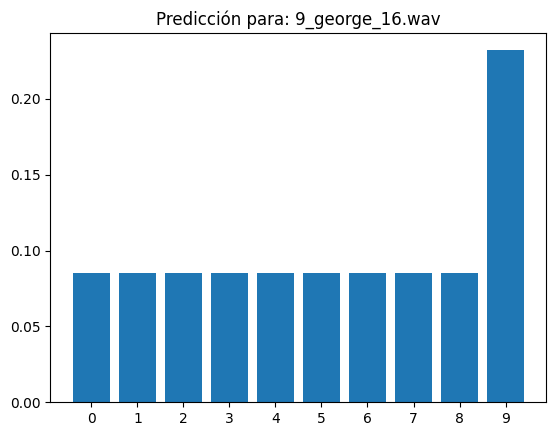

In [23]:
from pathlib import Path
data_dir = Path('organized_audio')  # Convertir a objeto Path
audio_path = data_dir / '9' / '9_george_16.wav'

# Cargar y procesar el audio
x = tf.io.read_file(str(audio_path))  # Convertir a string para tf.io.read_file
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
x = tf.squeeze(x, axis=-1)
waveform = x

# Obtener el espectrograma
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

# Realizar predicción
prediction = model(x)
x_labels = label_names

# Visualizar resultados
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predicción para: 9_george_16.wav')
plt.show()

# Reproducir audio
display.display(display.Audio(waveform, rate=8000))

Las probabilidades mostradas reflejan la confianza del modelo en cada dígito. **La sumatoria de las probabilidades siempre será 1.**

##RNN

Se diseña una red recurrente para la clasificación de audio.

In [ ]:
# NOTA: Celdas de entrenamiento comentadas para usar modelo pre-entrenado
# Descomentar solo si se necesita reentrenamiento desde cero [!]

In [ ]:
'''
# ---------- Preprocesamiento ----------
def preprocess_rnn_data(spectrogram, label):
    """
    Preprocesa los datos para una RNN:
    - Elimina la dimensión del canal
    - Normaliza por muestra
    """
    spectrogram = tf.squeeze(spectrogram, axis=-1)  # De (batch, tiempo, características, 1) a (batch, tiempo, características)

    # Normalización por muestra
    mean = tf.reduce_mean(spectrogram, axis=[1, 2], keepdims=True)
    std = tf.math.reduce_std(spectrogram, axis=[1, 2], keepdims=True)
    spectrogram = (spectrogram - mean) / (std + 1e-6)  # Añadir epsilon para evitar división por cero

    return spectrogram, label
'''

In [ ]:
'''
# Mostrar forma de ejemplo
for spec, _ in train_spectrogram_ds.take(1):
    print(f"Forma del espectrograma de ejemplo: {spec.shape}")
'''

Forma del espectrograma de ejemplo: (64, 61, 129, 1)


In [ ]:
'''
# Aplicar el preprocesamiento
train_rnn_ds = train_spectrogram_ds.map(preprocess_rnn_data, num_parallel_calls=tf.data.AUTOTUNE)
val_rnn_ds = val_spectrogram_ds.map(preprocess_rnn_data, num_parallel_calls=tf.data.AUTOTUNE)
'''

###Arquitectura

Se diseña una red recurrente para la clasificación de audio.

In [ ]:
'''
# ---------- Definición del modelo ----------
input_shape = next(iter(train_rnn_ds.take(1)))[0].shape[1:]  # (timesteps, features)
num_labels_rnn = len(label_names)

model_rnn = models.Sequential([
    layers.Input(shape=input_shape),  # input_shape: (tiempo, características)

    # Primera capa LSTM
    layers.LSTM(256, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),

    # Segunda capa LSTM
    layers.LSTM(128, dropout=0.1, recurrent_dropout=0.1),

    # Batch Normalization
    layers.BatchNormalization(),

    # Capa densa + Dropout
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    # Capa de salida
    layers.Dense(num_labels_rnn, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model_rnn.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_rnn.summary()
'''

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 61, 256)        │       395,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 601,802 (2.30 MB)

 Trainable params: 601,546 (2.29 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
'''
# ---------- Callbacks ----------
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )
]
'''

###Entrenamiento

In [ ]:
'''
EPOCHS = 50
history_rnn = model_rnn.fit(
    train_rnn_ds,
    validation_data=val_rnn_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)
'''

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.1486 - loss: 2.7024 - val_accuracy: 0.1233 - val_loss: 2.2801 - learning_rate: 5.0000e-04
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1873 - loss: 2.3547 - val_accuracy: 0.2350 - val_loss: 2.1721 - learning_rate: 5.0000e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2743 - loss: 1.9607 - val_accuracy: 0.2483 - val_loss: 1.9564 - learning_rate: 5.0000e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 986ms/step - accuracy: 0.3474 - loss: 1.7035 - val_accuracy: 0.4967 - val_loss: 1.7042 - learning_rate: 5.0000e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 995ms/step - accuracy: 0.4247 - loss: 1.4382 - val_accuracy: 0.5067 - val_loss: 1.3161 - learning_rate: 5.0000e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 995ms/step - accuracy: 0.5491 - loss: 1.1790 - val_accuracy: 0.6233 - val_loss: 0.9593 - learning_rate: 5.0000e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.597

###Resultados

In [ ]:
'''
# ---------- Mejor época ----------
best_epoch_index = history_rnn.history['val_loss'].index(min(history_rnn.history['val_loss']))

print(f"\nMejor época restaurada: {best_epoch_index + 1}")
print(f"Entrenamiento -> Loss: {history_rnn.history['loss'][best_epoch_index]:.4f} - Accuracy: {history_rnn.history['accuracy'][best_epoch_index]:.4f}")
print(f"Validación -> Loss: {history_rnn.history['val_loss'][best_epoch_index]:.4f} - Accuracy: {history_rnn.history['val_accuracy'][best_epoch_index]:.4f}")
'''


Mejor época restaurada: 24
Entrenamiento -> Loss: 0.0740 - Accuracy: 0.9879
Validación -> Loss: 0.0471 - Accuracy: 0.9900


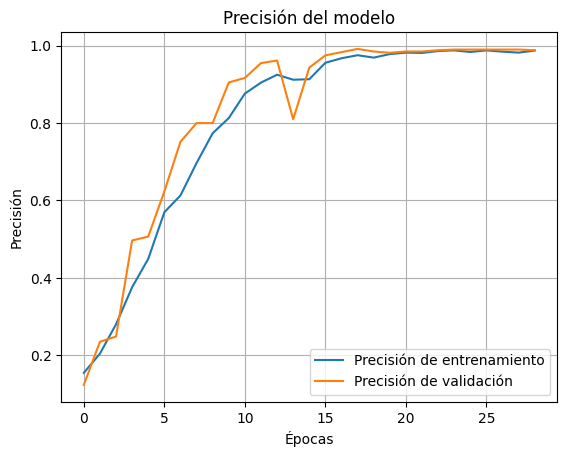

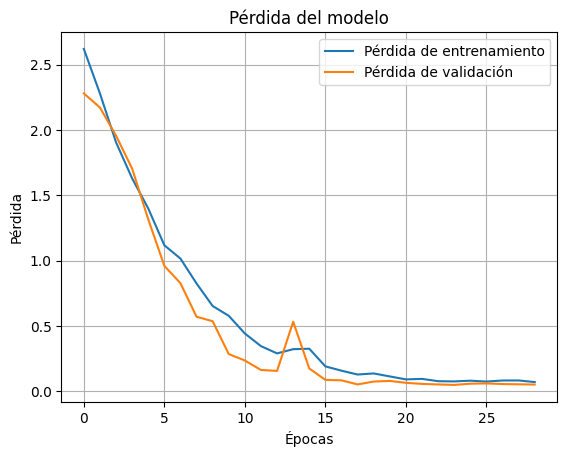

In [ ]:
'''
# ---------- Gráficos ----------
plt.plot(history_rnn.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history_rnn.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(history_rnn.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_rnn.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida del modelo')
plt.grid(True)
plt.legend()
plt.show()
'''

📌 **Análisis del entrenamiento:**

* Fase inicial (épocas 1-6):

  * Aprendizaje lento pero constante

  * Gran salto en val_accuracy (49.6%) en época 4

  * Pérdidas disminuyen rápidamente (val_loss de 2.28 → 0.96)

* Fase de crecimiento (épocas 7-12):

  * Mejora acelerada (val_accuracy sube de 75% a 95.5%)

  * Reducción drástica de val_loss (0.83 → 0.16)

  * Train y val convergen armónicamente

* Estabilización (épocas 13+):

  * Máximo rendimiento alcanzado (val_accuracy 96-99%)

  * Fluctuación en validación en época 14 (posible outlier)
    * ⬇️ Caída abrupta en val_accuracy
    * ⬆️ Aumento significativo en val_loss



📌 **Conclusiones clave:**

  ✓ La red superó el 90% de val_accuracy en solo 10 épocas

  ✓ Excelente generalización (gap mínimo train-val en últimas épocas)

  ✓ Los ajustes automáticos de LR optimizaron la convergencia final

  ✓ Entrenamiento eficiente con early stopping implícito

####Matriz de confusión

Se utiliza una matriz de confusión para verificar qué tan bien clasificó el modelo cada uno de los dígitos en el conjunto de validación:

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step


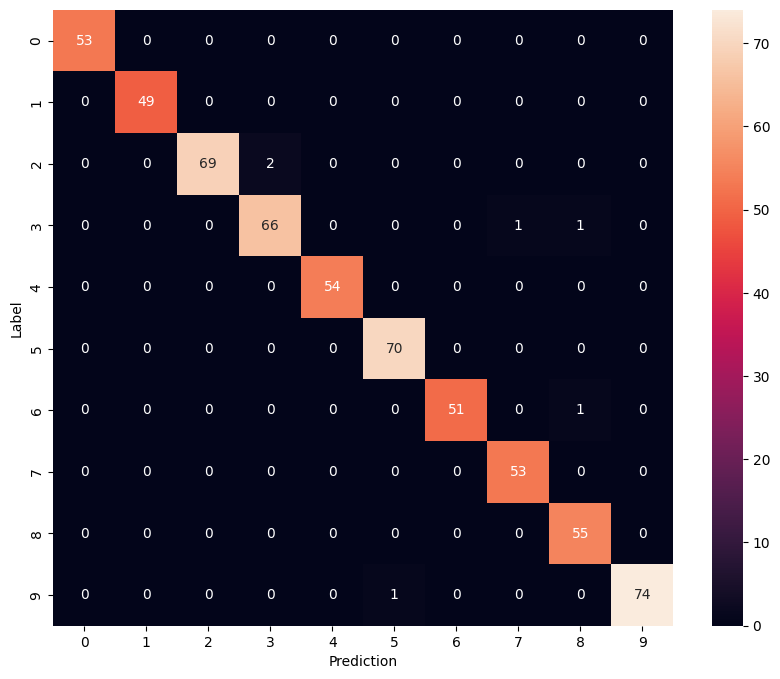

In [ ]:
'''
# ---------- Predicciones ----------
y_pred_rnn = model_rnn.predict(val_rnn_ds)
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)

# ---------- Etiquetas verdaderas ----------
y_true_rnn = tf.concat([labels for _, labels in val_rnn_ds], axis=0)

# ---------- Matriz de Confusión ----------
confusion_mtx = tf.math.confusion_matrix(y_true_rnn, y_pred_rnn)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
'''

In [ ]:
'''
# Se guarda el modelo como un archivo HDF5
model_rnn.save("model_rnn.h5")
'''

*Exploramos los errores en la clasificación de dígitos:*

In [ ]:
'''
# Obtener predicciones y etiquetas reales
y_true = np.concatenate([y.numpy() for _, y in val_rnn_ds])
y_pred = np.argmax(model_rnn.predict(val_rnn_ds), axis=1)

# Identificar errores
error_indices = np.where(y_true != y_pred)[0]
audio_samples = [audio.numpy() for audio, _ in val_ds.unbatch()]

print(f"\n Errores encontrados: {len(error_indices)}/{len(y_true)}")

# Mostrar cada error en el formato solicitado
for i, idx in enumerate(error_indices):
    audio = audio_samples[idx]
    true_label = y_true[idx]
    predicted_label = y_pred[idx]

    print(f"\nAudio {idx}:")
    print(f"✅ Etiqueta verdadera: {label_names[true_label]}")
    print(f"❌ Predicción del modelo: {label_names[predicted_label]}")

    # Reproducir audio
    print("🎧 Escucha:")
    display.display(display.Audio(audio, rate=8000, autoplay=False))
'''

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step

 Errores encontrados: 6/600

Audio 2:
✅ Etiqueta verdadera: 3
❌ Predicción del modelo: 8
🎧 Escucha:



Audio 156:
✅ Etiqueta verdadera: 3
❌ Predicción del modelo: 7
🎧 Escucha:



Audio 304:
✅ Etiqueta verdadera: 9
❌ Predicción del modelo: 5
🎧 Escucha:



Audio 333:
✅ Etiqueta verdadera: 6
❌ Predicción del modelo: 8
🎧 Escucha:



Audio 436:
✅ Etiqueta verdadera: 2
❌ Predicción del modelo: 3
🎧 Escucha:



Audio 512:
✅ Etiqueta verdadera: 2
❌ Predicción del modelo: 3
🎧 Escucha:


**Errores detectados (6 casos):**

📌 Coincidentes con CNN (4):

  - 2 audios mal etiquetados desde origen

  - 2 difíciles de clasificar por ambos modelos (casos límite)

📌 No coincidentes (2):

  - 2 audios bien clasificados por CNN

## **Conclusiones: Comparación CNN vs RNN**

📌 **Rendimiento Final**  
- **CNN**:  
  - *Mejor val_accuracy*: **97.17%** (época 27)  
  - *Velocidad*: Entrenamiento más rápido (~8s/época)  
  - *Estabilidad*: Progreso constante sin fluctuaciones bruscas  

- **RNN**:  
  - *Mejor val_accuracy*: **99.00%** (época 24)  
  - *Velocidad*: Entrenamiento más lento (~40s/época)  
  - *Dinámica*: Mayor variabilidad (ej. outlier época 14)  

<br>

📌 **Patrones de Aprendizaje**  
1. **CNN**:  
   - Aprendizaje acelerado en primeras épocas (val_accuracy >90% en época 10)  
   - Curvas suaves de loss/accuracy  
   - Early stopping en época 27 por estabilización  

2. **RNN**:  
   - Comienzo lento (val_accuracy 12.3% en época 1)  
   - Salto abrupto en época 10 (80.0% → 90.5%)  
   - Múltiples ajustes de learning rate (5 reducciones)  
   - Early stopping en época 29 (mejor modelo en época 24)  

<br>

📌 **Hallazgos Clave**    

  1. La **RNN superó** levemente a la CNN en accuracy final (99.0% vs 97.2%)
  2. La **CNN fue más estable** (sin grandes fluctuaciones en validación)
  3. Ambas arquitecturas mostraron **buena generalización** (gaps train-val)  

<br>

📌 **Insights finales**  
1. Para aplicaciones que priorizan **velocidad**: Usar CNN  
2. Para máxima **precisión**: Optar por RNN (con más recursos computacionales
3. Ambos modelos son exitosos (>95% val_accuracy), demostrando que las arquitecturas CNN y RNN son efectivas para clasificación de audio  